# Tutorial 7 - Recommender Systems Part I  

Recommender systems are one of the most common type of predictive model that a person may encounter. They provide the basis for personalized services in several online platforms, such as Amazon, Spotify, and Youtube. There is a myriad of data preparation techniques, algorithms, and model evaluation methods. In this tutorial, we will see how to load and explore datasets with users' feedback and how to play with basic recommendation techniques, such as non-personalized approaches and collaborative filtering approaches. Finally, we will introduce simple evaluation settings for rating prediction tasks. A few other recommendation algorithms and more extensive evaluation settings will be covered in the next lecture and tutorial.  


**Expected Tasks**

- Follow the recommender systems basic showcase.
- Solve a range of exercises throughout the notebook. 

**Learning Objectives**

- Load and explore dataset with users' feedback. 
- Implement non-personalized recommendation techniques. 
- Play with a user-based collaborative filtering technique.
- Play with an item-based collaborative filtering technique. 
- Play with an example matrix factorization technique, namely SVD.
- Play with a simple evaluation setting for rating prediction tasks.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sc
import math

%matplotlib inline

## The Movielens 1M data set
---

**Reference**: Harper, F. M., & Konstan, J. A. (2015). The Movielens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. [https://dl.acm.org/doi/10.1145/2827872](https://dl.acm.org/doi/10.1145/2827872). 

The MovieLens datasets, first released in 1998, describe people’s expressed preferences for movies. These preferences take the form of <user, item, rating, timestamp> tuples, each the result of a person expressing a preference (a 0–5 star rating) for a movie at a particular time. These preferences were entered by way of the MovieLens website, a recommender system that asks its users to give movie ratings in order to receive personalized movie recommendations. 

The MovieLens datasets are heavily downloaded and referenced in the research literature. This popularity is, to a certain degree, a reflection of the incredible rate of growth of personalization and recommendation research, in which datasets such as these have substantial value in exploring and validating ideas. The popularity might also be attributed to the flexibility of ratings data. Also, because movie preferences are highly subject to personal tastes, the movie domain is well suited to testing personalization technology. Finally, the popularity may reflect the perceived accessibility of movies as a content domain: movies are a common interest, making algorithmic output easy to discuss. 

In this tutorial, we will play with a small version of a dataset collected from the Movielens platform. Specifically, we will use the MovieLens 1M movie ratings dataset ([https://grouplens.org/datasets/movielens/1m/](https://grouplens.org/datasets/movielens/1m/)), with 1 million ratings from 6000 users on 4000 movies. The dataset includes information about **ratings**, **movies**, **users**. 

All **ratings** are contained in the file "ratings.dat" and are in the following format: user_id::item_id::rating::timestamp. 
- User IDs range between 1 and 6040. 
- Item IDs range between 1 and 3952.
- Ratings are made on a 5-star scale (whole-star ratings only). 
- Timestamp is represented in seconds since the epoch as returned by time. 
- Each user has at least 20 ratings. 

In [2]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')

In [3]:
ratings.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The **movies** information is in the file "movies.dat" and is in the following format: item_id::title::genres. 

- Titles are identical to titles provided by the IMDB (including year of release). 
- Genres are pipe-separated and are selected from the following genres:
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
- Some MovieIDs do not correspond to a movie due to accidental duplicate entries and/or test entries. 
- Movies are mostly entered by hand, so errors and inconsistencies may exist. 

In [4]:
items = pd.read_csv('./ml-1m/movies.dat', sep='::', names=['item_id', 'title', 'genres'], engine='python')

In [5]:
items.head()

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


The **user** information is in the file "users.dat" and is in the following format: user_id::gender::age::occupation::zip. All demographic information is provided voluntarily by the users and is not checked for accuracy.  Only users who have provided some demographic information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female. 
- Age is chosen from the following ranges:
	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"


In [6]:
users = pd.read_csv('./ml-1m/users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip'], engine='python')

In [7]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Preliminary exploration
---

A preliminary exploratory analysis can allow us to uncover the underlying structure of a data set and is important because it exposes trends, patterns, and relationships about the users' feedback that are not readily apparent. Due to the time constraints, in this tutorial, we cover only some basic explorative steps aimed at inspecting the distribution of ratings across users and items. We will provide you some hints on other aspects you can consider in your exploratory analysis and, based on the time during the tutorial or after the tutorial you can work on top of those hints.   

Compute the total number of ratings, the number of unique users, and the number of unique items. 

In [8]:
### EXERCISE CELL ###
len(ratings), len(ratings['user_id'].unique()), len(ratings['item_id'].unique())

(1000209, 6040, 3706)

Plot the distribution of ratings. 

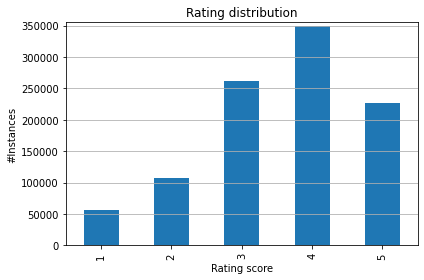

In [9]:
### EXERCISE CELL ###
plt.title('Rating distribution')
ratings_dist = ratings.groupby('rating')['rating'].count()
ratings_dist.plot(kind='bar')
plt.xlabel('Rating score')
plt.ylabel('#Instances')
plt.ylim([0, 355000])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Plot the distribution of (i) the number of ratings per user and (ii) the number of ratings per item.

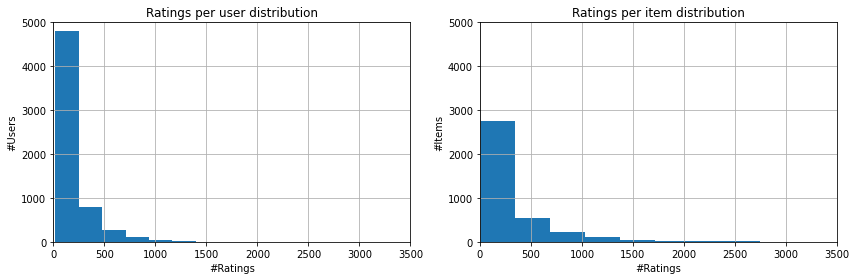

In [10]:
### EXERCISE CELL ###
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Ratings per user distribution')
ratings_per_user = ratings.groupby('user_id')['rating'].count()
ratings_per_user.hist()
plt.ylim([0, 5000])
plt.xlim([0, 3500])
plt.xlabel('#Ratings')
plt.ylabel('#Users')

plt.subplot(1, 2, 2)
plt.title('Ratings per item distribution')
ratings_per_item = ratings.groupby('item_id')['rating'].count()
ratings_per_item.hist()
plt.ylim([0, 5000])
plt.xlim([0, 3500])
plt.xlabel('#Ratings')
plt.ylabel('#Items')

plt.tight_layout()
plt.show()

Plot the distribution of (i) the average rating per user and (ii) the average rating per item.

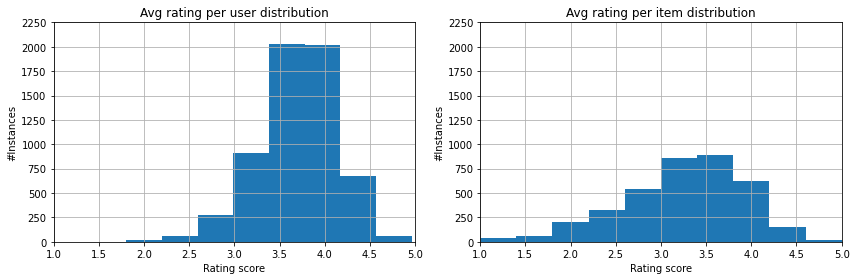

In [11]:
### EXERCISE CELL ###
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Avg rating per user distribution')
ratings_per_user = ratings.groupby('user_id')['rating'].mean()
ratings_per_user.hist()
plt.xlim([1, 5])
plt.ylim([0, 2250])
plt.xlabel('Rating score')
plt.ylabel('#Instances')

plt.subplot(1, 2, 2)
plt.title('Avg rating per item distribution')
ratings_per_item = ratings.groupby('item_id')['rating'].mean()
ratings_per_item.hist()
plt.xlim([1, 5])
plt.ylim([0, 2250])
plt.xlabel('Rating score')
plt.ylabel('#Instances')

plt.tight_layout()
plt.show()

What can you observed from the above plots? Which other explorative tasks could be useful to get more insights on the data set?


The above explorative plots represent just a few examples of the multitude analyses you can run to better know the data set at hand. We invite you to inspect any other possible explorative task that may be need and discuss it during the tutorial. 

Other explorations may involve the following aspects, for instance:
- relationships between ratings distribution for specific segments of users or items (e.g., the average rating given by users across item genres);
- relantionships between ratings and timestamps that can be useful to understand the extent to which the release of ratings changes across time;
- and so on.... 

## Preliminary pre-processing

Based on the findings of your exploratory analysis, you may need to pre-process the data set accordingly. For instance, from the above number of ratings per item distribution, it can be observed that there are a lot of items which have received only a few ratings. Recommendations for that items can become noisy, and we usually do not want to provide recommendations for items by relying on ratings provided by only a few users. Hence, we can filter only items which have received at minimum number of ratings. In the following cell, you can provide the code to filter only ratings for items that received at least $50$ ratings. 

In [12]:
### EXERCISE CELL ###
ratings_per_item = ratings.groupby('item_id')['rating'].count()
items_to_remove = ratings_per_item[ratings_per_item < 50]
ratings = ratings[~ratings['item_id'].isin(items_to_remove.index)]

len(ratings), len(ratings['user_id'].unique()), len(ratings['item_id'].unique())

(977839, 6040, 2514)

This is just an example of how your exploratory analysis may drive your decisions on the subsequent steps of the recommendation pipeline. We invite you to inspect any other possible pre-processing task that may be need and discuss it during the tutorial. 

Note that pre-processing tasks related to the evaluation of a recommender system (e.g., train-test splits) will be covered in the next week's tutorial, where we will delve into the evaluation methods and performance metrics used to assess the quality of recommendations provided to users. 

## Non-personalized recommendation
---

Non-personalized recommendations are usually where most platforms start because it is easy and does not require that you know anything specific about the users. Non-personalized recommendations are good because you can always show those, despite how little you know about the users. In same cases, it is said that non-personalized recommendations should only be shown until the platform knows enough about the user to show more personalized recommendations, but this is not generally true, given that people is usually interested in what is popular or appreciated by their peers, on average. Furthermore, it has been often proved that non-personalized recommender systems are good baselines (we will see this deeply in the next tutorial). Therefore, in this section, we will generate non-personalized recommendations according to same well-known indicators. 

Extend the items dataframe with the additional columns: average rating and number of received ratings.

In [13]:
### EXERCISE CELL ###

# Create a dataframe with information about the average rating per item
avg_ratings = ratings.groupby('item_id')['rating'].mean()
avg_ratings.name = 'avg_rating'
avg_ratings.head()

# Create a dataframe with information about the number of received ratings per item
num_ratings = ratings.groupby('item_id')['rating'].count()
num_ratings.name = 'num_ratings'
num_ratings.head()

# Merge the two create dataframes with the original items dataframe
items = items.merge(avg_ratings, left_on='item_id', right_index=True)
items = items.merge(num_ratings, left_on='item_id', right_index=True)

# Show the extended items dataframe
items.head()

,item_id,title,genres,avg_rating,num_ratings
0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141,701
2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736,478
3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412,170
4,5,Father of the Bride Part II (1995),Comedy,3.006757,296


Sort items by decreasing average rating and show the dataframe rows for the top 10 items with the highest average rating. 

In [14]:
### EXERCISE CELL ###
items.sort_values('avg_rating', ascending=False).head(10)

,item_id,title,genres,avg_rating,num_ratings
2836,2905,Sanjuro (1962),Action|Adventure,4.608696,69
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,4.560510,628
315,318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227
847,858,"Godfather, The (1972)",Action|Crime|Drama,4.524966,2223
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,4.520548,657
49,50,"Usual Suspects, The (1995)",Crime|Thriller,4.517106,1783
523,527,Schindler's List (1993),Drama|War,4.510417,2304
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy,4.507937,882
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir,4.491489,470
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,4.477725,2514


Sort items by decreasing number of received ratings and show the dataframe rows for the top 10 items with the highest  number of received ratings. 

In [15]:
### EXERCISE CELL ###
items.sort_values('num_ratings', ascending=False).head(10)

,item_id,title,genres,avg_rating,num_ratings
2789,2858,American Beauty (1999),Comedy|Drama,4.317386,3428
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.292977,2990
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,4.022893,2883
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,3.763847,2672
1959,2028,Saving Private Ryan (1998),Action|Drama|War,4.337354,2653
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,4.058513,2649
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.315830,2590
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,3.990321,2583
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,4.351823,2578


Another common non-personalized recommendation approach is based on the time the item is released, that is the year the movie has been released, in our data set. Therefore, we can show a list with the 10 most recent items, by sorting items according to the release date that is included in the movie title. To this end, we can first extent the items dataframe with a column entitled "release_date" and then appropriately sort the resulting dataframe according to this column. 

In [16]:
### EXERCISE CELL ###
items['release_date'] = items['title'].apply(lambda x: int(x.split('(')[-1][:4]))
items.sort_values('release_date', ascending=False).head(10)

,item_id,title,genres,avg_rating,num_ratings,release_date
3882,3952,"Contender, The (2000)",Drama|Thriller,3.780928,388,2000
3682,3751,Chicken Run (2000),Animation|Children's|Comedy,3.879609,1329,2000
3446,3515,Me Myself I (2000),Comedy,3.187500,192,2000
3465,3534,28 Days (2000),Comedy,3.065347,505,2000
3466,3535,American Psycho (2000),Comedy|Horror|Thriller,3.219048,630,2000
3467,3536,Keeping the Faith (2000),Comedy|Romance,3.748466,489,2000
3485,3554,Love and Basketball (2000),Drama|Romance,3.453782,119,2000
3486,3555,U-571 (2000),Action|Thriller,3.539648,908,2000
3495,3564,"Flintstones in Viva Rock Vegas, The (2000)",Children's|Comedy,1.804688,128,2000
3496,3565,Where the Heart Is (2000),Comedy|Drama,3.267148,277,2000


Which other non-personalized approaches could you apply to this data set? How do they relate with the recommendation domain? We invite you to think about this aspect during the tutorial and, during or after the tutorial, you could extend this part with additional non-personalized approaches. We invite you to think, inspect, and discuss this aspect during the tutorial. 

What we provided above represents just a few examples of non-personalized approaches you could consider. Other approaches may consider the following indicators, for instance:
- create a list of most popular items (i.e., with the highest number of received ratings) for each genre;
- create a list with the most popular items in the last period of time (e.g., the last year);
- and so on.... 

## Personalized recommendation

Personalized recommendations are often part of a platform personalization strategy wherein listof suggested items are dynamically populated to a user on a webpage, app, or email based on data such as customer attributes, browsing behavior, or situational context. In this tutorial, we will provide personalized recommendations according to the explicit feedback (ratings) provided by each user to movies. 


To experiment with different algorithms, we will rely on [Surprise](http://surpriselib.com/), a Python scikit for building and analyzing recommender systems that deal with explicit rating data. The Surprise code is available on [Github](https://github.com/NicolasHug/Surprise), so you could easily inspect how each algorithm has been implemented in detail. While it is in maintainance mode, it represents one of the simplest packages to adopt to start working with baseline algorithms, and it can be still used to run experiments on baseline algorithms you can compare against your recommendation strategy (in a possible class project). One of the main features is that it provides an interface similar to that in scikit-learn.   

From the documentation, we report here some of the key components of the library:

- Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
- Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
- Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
- Make it easy to implement new algorithm ideas.
- Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

Please, consider that there are many other Python packages for recommendation, such as [LensKit](https://lenskit.org/), [Elliot](https://github.com/sisinflab/elliot), [LightFM](https://github.com/lyst/lightfm), [TensorRec](https://github.com/jfkirk/tensorrec), and [TensorflowRecommender](https://www.tensorflow.org/recommenders). 

### Package installation

First, we install the Surprise package.  

In [17]:
%pip install surprise 

Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Data loading

Given that we have already load a dataframe with our ratings, we need to properly initialize a Surprise's dataset object by using the method <code>Dataset.load_from_df</code>. This method takes as an input a dataframe with three columns (user_id, item_id, and rating, in that order) and a Reader object which defines the rating scale. 

In [18]:
from surprise import Dataset, Reader

data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], Reader(rating_scale=(1, 5)))

Note that Surprise also includes pre-defined routines to download and load well-known datasets, such as other versions of the Movielens dataset, e.g., <code>data = Dataset.load_builtin('ml-100k')</code> to load the Movielens 100k data set. Please, find more information in the [Dataset](https://surprise.readthedocs.io/en/stable/dataset.html) module description. 

### Data splitting

Often, we are interested in training our recommendation model on a portion of the data set and testing on another unseen portion of the data set. In this tutorial, we apply a train_test_split() strategy to sample a trainset and a testset with given sizes. We will also see how to run a cross-validation evaluation method in brief. Please, note that both the evaluation methods (train_test_split and cross-validation) implemented in Surprise randomly split ratings in training and test sets (folds). While this has been extensively done in the literature, there are other splitting strategies that allow us to have evaluation scenarios better connected with the usage of the recommendation model in the real-world. We will cover these additional splitting strategies in the next lecture and lab session. 

In [19]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

### Model initialization

Once you have loaded and splitted your data, it is time to decide the recommendation algorithm you want to use according to the analytical dimensions we have seen in last lecture. In this tutorial, we will just consider the memory-based collaborative filtering approaches (user-based and item-based) and the Singular Value Decomposition (SVD) approach covered in last lecture. 

#### Memory-based approaches

Collaborative filtering is an approach for making automatic predictions (filtering) about the interests of a user by collecting the **preferences from many users** (collaborative). This can be especially relevant for the end-users, since these recommendations are derived from their and **other’s user-interactions** with the platform and can help them make a relevant selection of all items. The underlying assumptions of a collaborative filtering approach is that “if person A has the same opinion as person B on an item, A is more likely to have B’s opinion on a different item than a randomly chosen person”. It has proven its usefulness in systems implemented by Netflix, Spotify, Amazon and the like.

Specifically, in the lecture, we have covered two strategies:
- In a user-based collaborative filtering approach, for a user U, with a set of similar users determined based on rating vectors consisting of given item ratings, the rating for an item I, which hasn’t been rated, is found by picking out N users from the similarity list who have rated the item I and calculating the rating based on these N ratings.
- In a item-based collaborative filtering approach, for an item I, with a set of similar items determined based on rating vectors consisting of received user ratings, the rating by a user U, who hasn’t rated it, is found by picking out N items from the similarity list that have been rated by U and calculating the rating based on these N ratings.

These two strategies are implemented in Surprise via the [KNNs](https://surprise.readthedocs.io/en/stable/knn_inspired.html#k-nn-inspired-algorithms) object. An important parameter for these k-NN-based algorithms in Surprise is <code>sim_options</code>, which describes options for similarity calculation. Using sim_options, you can set how similarity is calculated, such as similarity metrics. Specifically:
- With <code>'user_based'=True</code>, you could implement a user-based approach; with <code>'user_based'=False</code> an item-based approach is implemented.
- With the key <code>'name'</code>, you can set the similarity/distance measure for the corresponding approach. The default setting is using the Mean Squared Difference (<code>MSD</code>). However, we have seen how Pearson Correlation (<code>pearson</code>) can be used in case of a user-based approach and cosine similarity (<code>cosine</code>) or its variants can be used for an item-based approach.  

Another important parameter is represented by <code>k</code> (int), i.e., the maximum number of neighbors to take into account for aggregation. Default is 40.

In [20]:
from surprise import KNNBasic

sim_options = {'name': 'pearson', 'user_based': 'True'}
userknn_basic = KNNBasic(k=10, sim_options = sim_options) # user-based collaborative filtering

In [21]:
sim_options = {'name': 'cosine', 'user_based': 'False'}
itemknn_basic = KNNBasic(k=10, sim_options = sim_options) # item-based collaborative filtering

The above approaches do not take into account the mean ratings of each user in the prediction formula. As we have seen in the lecture, taking into account the mean ratings of each user is important to ensure that noisy patterns in the ratings do not negatively influence the predictions. To consider mean ratings of each user, you should use the Surprise's <code>KNNWithMeans</code> object. More information on the formulas and the parameters can be found [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans).   

In [22]:
from surprise import KNNWithMeans

sim_options = {'name': 'pearson', 'user_based': 'True'}
userknn_means = KNNWithMeans(k=10, sim_options = sim_options) # user-based collaborative filtering, mean ratings 

In [23]:
sim_options = {'name': 'cosine', 'user_based': 'False'}
itemknn_means = KNNWithMeans(k=10, sim_options = sim_options) # item-based collaborative filtering, mean ratings 

In the lecture, we have also seen how to include a baseline rating estimate. To implement this aspect in Surprise, you should use the Surprise's <code>KNNBaseline</code> object. More information on the formulas and the parameters can be found [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline).   

In [24]:
from surprise import KNNBaseline

sim_options = {'name': 'pearson', 'user_based': 'True'}
bsl_options = {'method': 'sgd'}
userknn_base = KNNBaseline(k=10, sim_options = sim_options, bsl_options = bsl_options) # user-based collaborative filtering, baseline rating 

In [25]:
sim_options = {'name': 'cosine', 'user_based': 'False'}
itemknn_base = KNNBaseline(k=10, sim_options = sim_options, bsl_options = bsl_options) # item-based collaborative filtering, baseline rating

#### Model-based approaches

Given that often the rating matrix is mostly empty, **reducing dimensions** can improve the performance of the algorithm in terms of both space and time. This lead use to approaches which involve a step to reduce or compress the large but sparse user-item matrix. Matrix factorization can be seen as **breaking down a large matrix** into a **product of smaller ones**. This is similar to the factorization of integers, where 12 can be written as 6 x 2 or 4 x 3. In the case of matrices, a matrix A with dimensions m x n can be reduced to a product of two matrices X and Y with dimensions m x p and p x n respectively (in matrix multiplication, a matrix X can be multiplied by Y only if the number of columns in X is equal to the number of rows in Y. Therefore the two reduced matrices have a common dimension p). The reduced matrices actually represent the users and items individually. The m rows in the first matrix represent the m users, and the p columns tell you about the features or characteristics of the users. The same goes for the item matrix with n items and p characteristics. 

One of the popular algorithms to factorize a matrix is the **Singular Value Decomposition (SVD)** algorithm. Collaborative Filtering can be formulated by approximating a matrix $R$ by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations. 

The general equation can be expressed as $R = U \Sigma V^T$

Given $m x n$ matrix $R$:
- $U$ is an ($m x r$) orthogonal matrix. 
- $\Sigma$ is an ($r x r$) diagonal matrix with non-negative real numbers on the diagonal. 
- $V^T$ is an ($r x n$) orthogonal matrix. 

Elements on the diagonal in $\Sigma$ are known as singular values of $R$. Matrix $R$ can be factorized to $U$, $\Sigma$ and $V$. The $U$ matrix represents the feature vectors corresponding to the users in the hidden feature space and the $V$ matrix represents the feature vectors corresponding to the items in the hidden feature space. The predictions can be made by taking product of $U$, $\Sigma$ and $V^T$.

The Surprise package includes an object named <code>SVD</code> which implements this approach. Specifically, among the main parameters taken by the SVD object, the following ones are included:
- n_factors: the number of factors. Default is 100.
- n_epochs: the number of iteration of the SGD procedure. Default is 20.
- biased (bool): whether to use baselines (or biases) estimations. Default is True.

Please, find more information about SVD and other matrix factorization approaches [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html). 

In [26]:
from surprise import SVD
svd = SVD(n_factors=10)

Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. More recent work minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting, as we will see in the following lecture and lab session. 

### Model fitting

Now, we are ready to fit our model. Similarly to scikit-learn, we need to call the method <code>fit</code> on the model object. We will fit the mode with the training data previously prepared, namely <code>trainset</code>. 

In [27]:
%time svd.fit(trainset)

Wall time: 18 s


### Rating prediction

Once we have fitted our model, we can predict the ratings on the test set <code>testset</code>. To get predictions on the full test set, Surprise requirs you to use the <code>test</code> method. 

In [28]:
%time predictions = svd.test(testset)

Wall time: 2.89 s


We show the first five predictions.

In [29]:
predictions[:5]

[Prediction(uid=563, iid=2010, r_ui=3.0, est=3.643971810026659, details={'was_impossible': False}),
 Prediction(uid=4014, iid=1374, r_ui=5.0, est=4.656177677492348, details={'was_impossible': False}),
 Prediction(uid=23, iid=3000, r_ui=4.0, est=3.729322752234926, details={'was_impossible': False}),
 Prediction(uid=238, iid=1096, r_ui=5.0, est=3.8583972036164518, details={'was_impossible': False}),
 Prediction(uid=3108, iid=2145, r_ui=3.0, est=3.345707028742338, details={'was_impossible': False})]

The above predictions are sorted according to the testset. This is confirmed by showing the first five interactions in the test set.  

In [30]:
testset[:5]

[(563, 2010, 3.0),
 (4014, 1374, 5.0),
 (23, 3000, 4.0),
 (238, 1096, 5.0),
 (3108, 2145, 3.0)]

While we will use built-in Surprise's functions to compte errors in terms of Root Mean Squared Error (RMSE), you could easily convert the above predictions into a list and use the scikit-learn metrics or any other custom error metric outside Surprise.  

Finally, to the the prediction for a specific user-item pair, you could use the <code>predict</code> method. 

In [31]:
uid = 196  # target user id
iid = 302  # target item id

# get a prediction for specific users and items.
pred = svd.predict(uid, iid, r_ui=4, verbose=True)

user: 196        item: 302        r_ui = 4.00   est = 3.70   {'was_impossible': False}


### Model evaluation

Finally, you could use the <code>predictions</code> object returned by the test method in order to assess the accuracy of the model under consideration. Surprise includes MAE, MSE, and RMSE by default. If you need to compute any other metric, you should transform the predictions in a list or numpy array and compute the metric score outside Surprise.   

In [32]:
from surprise import accuracy
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8748


0.874829672400887

### Cross validation

The Surprise's <code>cross_validate()</code> function runs a cross-validation procedure according to the cv argument, and computes some accuracy measures, as similarly done by scikit-learn. We are here using a classical 10-fold cross-validation, but fancier iterators can be used (see [here](https://surprise.readthedocs.io/en/stable/model_selection.html#cross-validation-iterators-api)). Please, note again that both the cross-validation implemented in Surprise randomly split ratings in training and test folds. While this has been extensively done in the literature, there are other splitting strategies that allow us to have evaluation scenarios better connected with the usage of the recommendation model in the real-world. We will cover these additional splitting strategies in the next lecture and lab session.

In [33]:
from surprise.model_selection import cross_validate
svd = SVD(n_factors=10)
%time cv_results = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8712  0.8711  0.8708  0.8697  0.8716  0.8709  0.0006  
Fit time          19.47   32.42   21.93   23.13   22.03   23.80   4.48    
Test time         2.75    2.59    2.73    2.47    3.09    2.73    0.21    
Wall time: 2min 25s


The method returns the following results:

In [34]:
cv_results

{'test_rmse': array([0.87121252, 0.87109773, 0.87082988, 0.86968273, 0.87157795]),
 'fit_time': (19.47050380706787,
  32.42223501205444,
  21.9284508228302,
  23.12898898124695,
  22.03060817718506),
 'test_time': (2.751086473464966,
  2.5918989181518555,
  2.7267227172851562,
  2.474750280380249,
  3.092585325241089)}

## Closing Exercises

### Exercise #1

Evaluate three models under a 5-fold cross-validation and compute RMSE as evaluation metric. Then, report the RMSE scores across folds for each model using error bars or box plots. Specifically, you need to consider three SVD models with the following three values of n_factors: 5, 10, 15. In this tutorial, we just propose these small n_factors values due to the time constraints, but you would need to test across a more extensive range in other contexts.  

In [35]:
### EXERCISE CELL ###
measures=['RMSE']
verbose=False
cv = 5

metrics = {}
for n_factors in [5, 10, 15]:
    print('Computing for {} factors'.format(n_factors))
    svd = SVD(n_factors=n_factors)
    %time cv_results = cross_validate(svd, data, measures=measures, cv=cv, verbose=verbose)
    metrics['SVD-' + str(n_factors)] = cv_results['test_rmse']

Computing for 5 factors
Wall time: 2min 14s
Computing for 10 factors
Wall time: 2min 19s
Computing for 15 factors
Wall time: 2min 26s


In [36]:
metrics

{'SVD-5': array([0.87426745, 0.87955235, 0.87516712, 0.88087102, 0.87638815]),
 'SVD-10': array([0.86859944, 0.87197671, 0.87630904, 0.87110372, 0.87330927]),
 'SVD-15': array([0.86771341, 0.87079246, 0.87098911, 0.86852473, 0.87126992])}

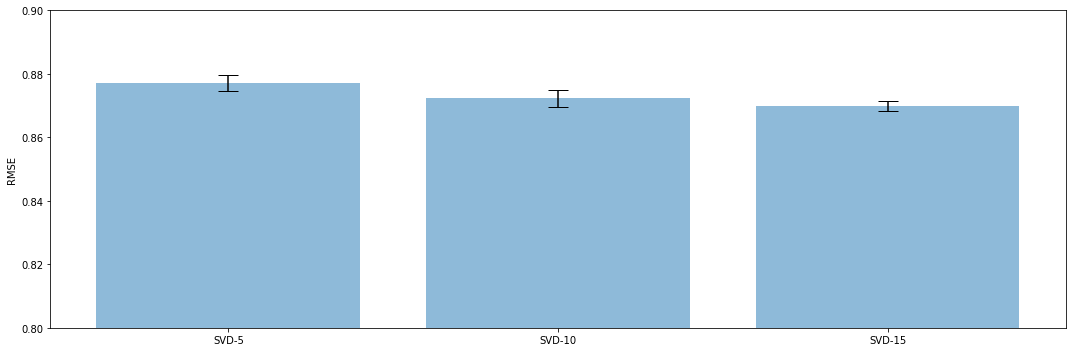

In [37]:
plt.figure(figsize=(15, 5))

# Compute means, standard deviations, and labels
means, yerrs, labels = [], [], []
for model, model_scores in metrics.items():
    means.append(np.mean(model_scores))
    yerrs.append(np.std(model_scores))
    labels.append(model)

# Plot values
x_pos = np.arange(len(labels))
plt.bar(x_pos, means, yerr=yerrs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Make decorations
plt.xticks(x_pos, labels)
plt.ylabel('RMSE')
plt.ylim(.8, .9)

plt.tight_layout()
plt.show()

### Exercise #2

Evaluate three models under a train-test split (with a test size of .20) and compute RMSE as evaluation metric. Then, print the RMSE score for each model (assumption due to time constraints). Specifically, you need to consider the following models:
- A basic item-based collaborative filtering approach (KNNBasic, cosine, k=15).
- An item-based collaborative filtering approach which takes into account the mean rating per user (KNNWithMeans, cosine, k=15).
- An item-based collaborative filtering approach which takes into account the baseline rating estimate (KNNBaseline, cosine, k=15, method='sgd')

In [38]:
### EXERCISE CELL ###
sim_options = {'name': 'cosine', 'user_based': 'False'}
bsl_options = {'method': 'sgd'}
k=15

trainset, testset = train_test_split(data, test_size=.20)

for model_type in [KNNBasic, KNNWithMeans, KNNBaseline]:
    model = model_type(k=k, sim_options=sim_options, bsl_options=bsl_options) # user-based collaborative filtering
    model.fit(trainset)
    predictions = model.test(testset)
    rmse_score = accuracy.rmse(predictions, verbose=False)
    print('Model={} RMSE={}'.format(model_type, rmse_score))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Model=<class 'surprise.prediction_algorithms.knns.KNNBasic'> RMSE=0.9923756586148448
Computing the cosine similarity matrix...
Done computing similarity matrix.
Model=<class 'surprise.prediction_algorithms.knns.KNNWithMeans'> RMSE=0.9590556853886992
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Model=<class 'surprise.prediction_algorithms.knns.KNNBaseline'> RMSE=0.9157976352582142


Once you finish these exercises, during or after the tutorial, you could move on the following experiments, as examples:
- Compare performance across item-based and user-based approaches. 
- Compare performance among user-based (item-based) approaches that use different similarity metrics. 
- Replicate this type of analysis on another data set (e.g., Movielens 100k or another recommendation data set).
- ... and more

## Summary
---

In this tutorial, we have presented a gentle introduction to explicit feedback data and basic recommendation algorithms. First, we loaded and preliminarily explored the Movielens 1M dataset. Then, we played with a user-based and an item-based collaborative filtering algorithm. Finally, we have seen how to play with a matrix factorization strategy based on a singular value decomposition. The performance of these three algorithms has been evaluated on example evaluation settings. Next week, we will cover other recommendation algorithms, and we will present a more extensive variety of performance metrics and evaluation methods. We will also see how to generate a top k list of recommend items, going beyond rating prediction.    